<font size="+3"><strong>Interactive Dashboard</strong></font>

In [1]:
import pandas as pd
import plotly.express as px
from dash import Input, Output, dcc, html
from jupyter_dash import JupyterDash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Prepare Data

## Import

In [2]:
def wrangle(filepath):

    """Read SCF data file into ``DataFrame``.

    Returns only credit fearful households whose net worth is less than $2 million.

    Parameters
    ----------
    filepath : str
        Location of CSV file.
    """
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"] == 1) & (df["NETWORTH"] < 2e6)
    df = df[mask]
    
    return df

In [3]:
df = wrangle("SCFP2019.csv")
print(df.shape)
df.head()

(4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


# Build Dashboard

## Application Layout

In [18]:
app = JupyterDash(__name__)

In [ ]:
server = app.server

In [37]:
app.layout = html.Div(children=[
        html.H1("Survey of Consumer Finances"),
        html.H2("High Variance Features"),
        dcc.Graph(figure=serve_bar_chart(), id="bar-chart", style={'margin' : '2rem'}),
        dcc.RadioItems(
            options=[
                {"label" : "trimmed", "value" : True},
                {"label" : "not trimmed", "value" : False}
            ],
            value=True,
            id="trim-button" , style={'margin' : '2rem'}
        ),
        html.H2("K-Means Clusturing"),
        html.H3("Number of Clusters (k)"),
        dcc.Slider(min=2, max=12, step=1, value=2, id="k-slider"),
        html.Div(id="metrics", style={'margin' : '2rem'}),  
    ], style={'padding': '4rem'})

## Variance Bar Chart

In [20]:
def get_high_var_features(trimmed=True, return_feat_names=True):

    """Returns the five highest-variance features of ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    return_feat_names : bool, default=False
        If ``True``, returns feature names as a ``list``. If ``False``
        returns ``Series``, where index is feature names and values are
        variances.
    """
    if trimmed:
        top_five_features = (
            df.apply(trimmed_var).sort_values().tail(5)
        )
    else:
        top_five_features = df.var().sort_values().tail(5)
        
    if return_feat_names:
        top_five_features = top_five_features.index.tolist()
    
    return top_five_features

In [21]:
@app.callback(
    Output("bar-chart", "figure"), Input("trim-button", "value")
)
def serve_bar_chart(trimmed=True):

    """Returns a horizontal bar chart of five highest-variance features.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.
    """
    top_five_features = get_high_var_features(trimmed=trimmed, return_feat_names=False)
    fig = px.bar(x=top_five_features, y=top_five_features.index, orientation='h')
    fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
    return fig

## K-means Slider and Metrics

In [22]:
def get_model_metrics(trimmed=True, k=2, return_metrics=False):

    """Build ``KMeans`` model based on five highest-variance features in ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.

    return_metrics : bool, default=False
        If ``False`` returns ``KMeans`` model. If ``True`` returns ``dict``
        with inertia and silhouette score.

    """
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    X=df[features]
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    
    if return_metrics:
        i = model.named_steps["kmeans"].inertia_
        ss = silhouette_score(X, model.named_steps["kmeans"].labels_)
        metrics = {
            "inertia" : round(i),
            "silhouette" : round(ss, 3), 
        }
        return metrics 
    
    return model

In [23]:
# @app.callback(
#     Output("metrics", "children"),
#     Input("trim-button", "value"),
#     Input("k-slider", "value")
# )
# def serve_metrics(trimmed=True, k=2):

#     """Returns list of ``H3`` elements containing inertia and silhouette score
#     for ``KMeans`` model.

#     Parameters
#     ----------
#     trimmed : bool, default=True
#         If ``True``, calculates trimmed variance, removing bottom and top 10%
#         of observations.

#     k : int, default=2
#         Number of clusters.
#     """
#     metrics = get_model_metrics(trimmed=trimmed, k=k, return_metrics=True)
#     text = [
#         html.H3(f"Inertia: {metrics['inertia']}"),
#         html.H3(f"Silhouette Score: {metrics['silhouette']}"),
#     ]
    
#     return text

## PCA Scatter Plot

In [24]:
def get_pca_labels(trimmed=True, k=2):

    """
    ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    X = df[features]
    transformer = PCA(n_components=2, random_state=42) 
    X_t = transformer.fit_transform(X)
    X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])
    model = get_model_metrics(trimmed=trimmed, k=k, return_metrics=False)
    X_pca["labels"] = model.named_steps["kmeans"].labels_.astype(str)
    X_pca.sort_values("labels", inplace=True)
    return X_pca

In [25]:
# @app.callback(
#     Output("pca-scatter", "figure"),
#     Input("trim-button", "value"),
#     Input("k-slider", "value")
# )
def serve_scatter_plot(trimmed=True, k=2):

    """Build 2D scatter plot of ``df`` with ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    fig=px.scatter(
        data_frame=get_pca_labels(trimmed=trimmed, k=k),
        x="PC1",
        y="PC2",
        color="labels",
        title="PCA Representation of Clusters"
    )
    fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
    return fig

In [26]:
@app.callback(
    Output("metrics", "children"),
    Input("trim-button", "value"),
    Input("k-slider", "value")
)
def serve_metrics(trimmed=True, k=2):

    """Returns list of ``H3`` elements containing inertia and silhouette score
    for ``KMeans`` model.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    metrics = get_model_metrics(trimmed=trimmed, k=k, return_metrics=True)
    text = [
        html.H3(f"Inertia: {metrics['inertia']}"),
        html.H3(f"Silhouette Score: {metrics['silhouette']}"),
        dcc.Graph(figure=serve_scatter_plot(trimmed=trimmed, k=k), id="pca-scatter"),
    ]
    
    return text

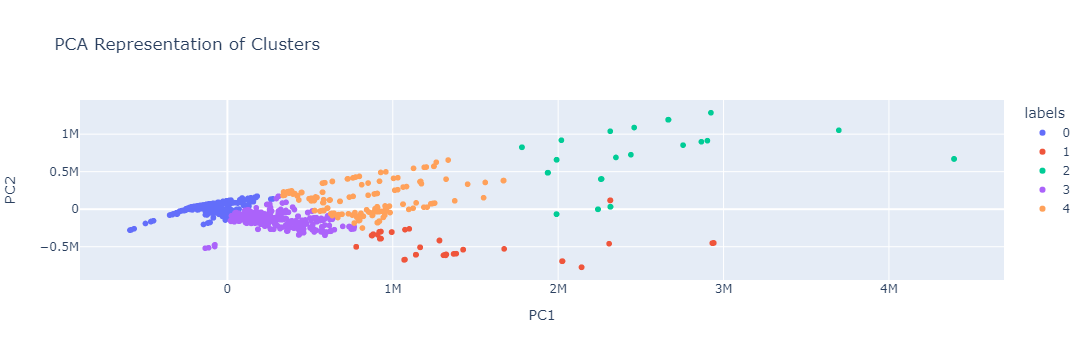

In [27]:
serve_scatter_plot(trimmed=False, k=5)

## Application Deployment

In [28]:
app.run_server(port = 8053, dev_tools_ui=True, #debug=True,
              dev_tools_hot_reload =True, threaded=True)

Dash app running on http://127.0.0.1:8053/
